# I’m Something of a Painter Myself - Use GANs to create art - will you be the next Monet?

### Jakub Kucera (kucerj56)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

/Users/jakubkucera/Documents/NI-MVI/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# if torch.backends.mps.is_available():
#     device = torch.device("mps") # Apple ARM GPU
# elif torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')

In [3]:
device = torch.device('cpu')

In [4]:
MONET_DATA_PATH = "./data-monet/monet/"
ORIG_DATA_PATH = "./data-monet/photo/"
BATCH_SIZE = 128
IMG_SIZE = 256
IMG_VALUE_COUNT = IMG_SIZE * IMG_SIZE
# IMG_VALUE_COUNT = IMG_SIZE * IMG_SIZE * 3
EPOCH_COUNT = 20

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

monet_dataset = ImageFolder(root=MONET_DATA_PATH, transform=transform)

orig_dataset = ImageFolder(root=ORIG_DATA_PATH, transform=transform)

In [6]:
monet_dataloader = torch.utils.data.DataLoader(monet_dataset, batch_size=BATCH_SIZE, shuffle=True)
orig_dataloader = torch.utils.data.DataLoader(orig_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# arr = np.swapaxes(next(iter(monet_dataloader))[0][111].numpy(), 2, 1)
# arr = next(iter(monet_dataloader))[0][111].numpy()[2]
arr = next(iter(monet_dataloader))[0][111].numpy().transpose((1, 2, 0))

In [8]:
for image, _ in orig_dataloader:
    print(np.shape(image))
    break

torch.Size([128, 3, 256, 256])


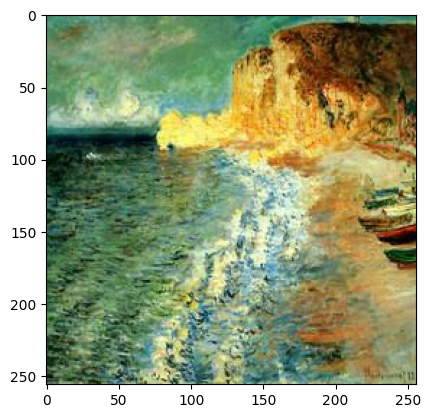

In [9]:
plt.imshow(arr, cmap='Greys_r')

In [10]:
class Generator(nn.Module):
    # TODO completely rewrite
    def __init__(self, gen_input_dim, gen_output_dim):
        super(Generator, self).__init__()
        # self.fc1 = nn.Linear(gen_input_dim, 256)
        # self.fc2 = nn.Linear(256, 512)
        self.fc1 = nn.Linear(gen_input_dim, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, gen_output_dim)

    # forward method
    def forward(self, x):
        # x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        return torch.tanh(self.fc3(x))

In [11]:
class Discriminator(nn.Module):
    # TODO use Convolutions and just completely rewrite
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    # forward method
    def forward(self, x):
        x = x.view(-1, 784) # TODO change
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [12]:
# TODO sort out dimensions
generator = Generator(gen_input_dim = IMG_VALUE_COUNT, gen_output_dim = IMG_VALUE_COUNT).to(device)
discriminator = Discriminator(IMG_VALUE_COUNT).to(device)

In [13]:
# TODO change
# loss
criterion = nn.BCELoss()
# optimizer
optimizer_gen = optim.Adam(generator.parameters(), lr = 0.0001)
optimizer_disc = optim.Adam(discriminator.parameters(), lr = 0.0001)

In [14]:
def label_real(b_size = BATCH_SIZE):
    data = torch.ones(b_size, 1)
    return data.to(device)

def label_fake(b_size = BATCH_SIZE):
    data = torch.zeros(b_size, 1)
    return data.to(device)

In [15]:
def train_discriminator(data_real,
                        labels,
                        data_fake,
                        generator = generator,
                        discriminator = discriminator,
                        optimizer = optimizer_disc,
                        batch_size = BATCH_SIZE
                        ):

    optimizer.zero_grad()
    discriminator.train()

    ones = label_real(data_real.shape[0])
    zeros = label_fake(data_real.shape[0])

    output_real = discriminator(data_real, labels)
    loss_real = criterion(output_real, ones)

    output_fake = discriminator(data_fake, torch.randint(0, 10, (image.shape[0], )).to(device))
    loss_fake = criterion(output_fake, zeros)

    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

In [16]:
def train_generator(data_fake,
                    labels = torch.randint(0, 10, (BATCH_SIZE, )).to(device),
                    generator = generator,
                    discriminator = discriminator,
                    optimizer = optimizer_gen,
                    batch_size = BATCH_SIZE
                    ):

    optimizer.zero_grad()
    generator.train()

    ones = label_real(data_fake.shape[0])

    output = discriminator(data_fake, labels)
    loss = criterion(output, ones)

    loss.backward()
    optimizer.step()

    return loss

In [18]:
loss_gen = []
loss_disc = []

for epoch in range(1, EPOCH_COUNT+1):

    print(f"Epoch #{epoch}")

    loss_g = 0.0
    loss_d = 0.0

    for image, _ in orig_dataloader:
        image = image.to(device)

        # run the discriminator for k number of steps
        for step in range(1):
            single_image = image[0]
            #make it black and white
            single_image_mono = single_image.mean(axis = 0)
            data_fake = generator(single_image_mono).detach()
            # data_fake = generator(create_noise(image.shape[0], noise_dim)).detach()
            data_real = image

            # train the discriminator network
            loss_d += train_discriminator(data_real, data_fake)
        # data_fake = generator(create_noise(image.shape[0], noise_dim))
        # TODO why is generate here 2 times?
        data_fake = generator(single_image_mono)

        # train the generator network
        loss_g += train_generator(data_fake,)

    loss_gen.append(loss_g.item())
    loss_disc.append(loss_d.item())

Epoch #1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x256 and 65536x512)